In [1]:
#ライブラリをインポート
#標準ライブラリ
import random
import pathlib

#サードパーティー製
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import timm
import torchinfo
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision

from PIL import Image
from torchvision import models, transforms
from tqdm import tqdm
from sklearn.metrics import(
    accuracy_score,
    ConfusionMatrixDisplay, confusion_matrix

)

#自作モジュール
from utils.Module import *

#乱数シードの設定
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [2]:
print(torch.__version__)

1.13.1


In [3]:
size = 32

# 概要

SwinTransformerを使用して、果物の分類モデルを作成する．<br>
基本的にはhttps://github.com/YutaroOgawa/pytorch_advanced/blob/master/1_image_classification/1-3_transfer_learning.ipynb
からコピペしている．

## 画像群を取得

In [4]:
#訓練画像のパス
list_train_path = list(pathlib.Path("Train").iterdir())
list_train_path = [str(path) for path in list_train_path]#str化

#推論画像のパス
list_val_path = list(pathlib.Path("Val").iterdir())
list_val_path = [str(path) for path in list_val_path]#str化

In [5]:
#from google.colab import drive
#drive.mount('/content/drive')

## 適用する水増し処理

In [6]:
# 入力画像の前処理をするクラス
# 訓練時と推論時で処理が異なる


class ImageTransform():
    """
    画像の前処理クラス。訓練時、検証時で異なる動作をする。
    画像のサイズをリサイズし、色を標準化する。

    Attributes
    ----------
    resize : int
        リサイズ先の画像の大きさ。
    mean : (R, G, B)
        各色チャネルの平均値。
    std : (R, G, B)
        各色チャネルの標準偏差。
    """

    def __init__(self, resize):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.Resize((size, size)), 
                transforms.ToTensor(),  # テンソルに変換
            ]),
            'val': transforms.Compose([
                transforms.Resize((size, size)),  # リサイズ
                transforms.ToTensor(),  # テンソルに変換
            ])
        }

    def __call__(self, img, phase='train'):
        """
        Parameters
        ----------
        phase : 'train' or 'val'
            前処理のモードを指定。
        """
        return self.data_transform[phase](img)

## データセットを作成

In [7]:
class Dataset(data.Dataset):
    """
    アリとハチの画像のDatasetクラス。PyTorchのDatasetクラスを継承。

    Attributes
    ----------
    file_list : リスト
        画像のパスを格納したリスト
    transform : object
        前処理クラスのインスタンス
    phase : 'train' or 'val'
        訓練か検証かを設定
    """

    def __init__(self, file_list, transform=None, phase='train'):
        self.file_list = file_list  # ファイルパスのリスト
        self.transform = transform  # 前処理クラスのインスタンス
        self.phase = phase  # train or valの指定

    def __len__(self):
        '''画像の枚数を返す'''
        return len(self.file_list)

    def __getitem__(self, index):
        '''
        前処理をした画像のTensor形式のデータとラベルを取得
        '''

        # index番目の画像をロード
        img_path = self.file_list[index]
        img = Image.open(img_path)  # [高さ][幅][色RGB]

        # 画像の前処理を実施
        img_transformed = self.transform(
            img, self.phase)  # torch.Size([3, 224, 224])
        
        # 画像のラベルをファイル名から抜き出す
        if(self.phase == "train"):
          label = list(pd.DataFrame(list_train_path).iloc[:, 0].str.split("\\", expand = True).iloc[:, -1].str.split("_", expand = True).iloc[:, 0])[index]
        else:
          label = list(pd.DataFrame(list_val_path).iloc[:, 0].str.split("\\", expand = True).iloc[:, -1].str.split("_", expand = True).iloc[:, 0])[index]


        # ラベルを数値に変更する
        if label == "apple":
            label = 0
        elif label == "tomato":
            label = 1
        elif label == "cherry":
            label = 2

        return img_transformed, label

In [8]:
# 実行
train_dataset = Dataset(
    file_list=list_train_path, transform=ImageTransform(size), phase='train')

val_dataset = Dataset(
    file_list=list_val_path, transform=ImageTransform(size), phase='val')

## DataLoaderの作成

In [9]:
# ミニバッチのサイズを指定
batch_size = 64

# DataLoaderを作成
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False)

# 辞書型変数にまとめる
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

## モデルをロード

In [10]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        self.cbr_1 = depthwiseseparableconv2DBatchNormRelu(
            3, 16, kernel_size=3, stride=1, padding=1, dilation=1, bias=True)
        self.cbr_2 = depthwiseseparableconv2DBatchNormRelu(
            16, 32, kernel_size=3, stride=1, padding=1, dilation=1, bias=True)
        self.cbr_3 = depthwiseseparableconv2DBatchNormRelu(
            32, 64, kernel_size=3, stride=1, padding=1, dilation=1, bias=True)
        self.maxpool2d = nn.MaxPool2d(3, stride=2, padding=1)
        self.conv = nn.Conv2d(64, 3, 3, stride = 1)
        self.flatten = nn.Flatten()     
        self.sigmoid = nn.Sigmoid()
        self.global_avg = nn.AdaptiveAvgPool2d((1,1))
        
    def forward(self, x):
        #畳み込み層
        x = self.maxpool2d(self.cbr_1(x))
        x = self.maxpool2d(self.cbr_2(x))
        x = self.maxpool2d(self.cbr_3(x))
        
        #全結合層
        x = self.flatten(self.global_avg(self.sigmoid(self.conv(x))))
        
        return x

In [11]:
model = Model()

In [12]:
torchinfo.summary(
    model,
    input_size=(batch_size, 3, 32, 32),
    col_names=["output_size", "num_params"],
)

Layer (type:depth-idx)                             Output Shape              Param #
Model                                              [64, 3]                   --
├─depthwiseseparableconv2DBatchNormRelu: 1-1       [64, 16, 32, 32]          --
│    └─Conv2d: 2-1                                 [64, 3, 32, 32]           84
│    └─BatchNorm2d: 2-2                            [64, 3, 32, 32]           6
│    └─ReLU: 2-3                                   [64, 3, 32, 32]           --
│    └─Conv2d: 2-4                                 [64, 16, 32, 32]          64
│    └─BatchNorm2d: 2-5                            [64, 16, 32, 32]          32
│    └─ReLU: 2-6                                   [64, 16, 32, 32]          --
│    └─Dropout2d: 2-7                              [64, 16, 32, 32]          --
├─MaxPool2d: 1-2                                   [64, 16, 16, 16]          --
├─depthwiseseparableconv2DBatchNormRelu: 1-3       [64, 32, 16, 16]          --
│    └─Conv2d: 2-8                  

## 損失関数の定義

In [13]:
# 損失関数の設定
criterion = nn.CrossEntropyLoss()

## 最適化手法を設定

In [14]:
# 最適化手法の設定
optimizer = optim.Adadelta(model.parameters())

## 学習と検証を実施

In [15]:
#decice = "cuda:0"
decice = "cpu"

In [16]:
# モデルを学習させる関数を作成


def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):
    #モデルをGPUへ
    net.to(decice)
    #lossを保存
    list_train_loss = []
    list_val_loss = []
    #正解率を保存
    list_train_acc = []
    list_val_acc = []

    # epochのループ
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')

        # epochごとの学習と検証のループ
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()  # モデルを訓練モードに
            else:
                net.eval()   # モデルを検証モードに

            epoch_loss = 0.0  # epochの損失和
            epoch_corrects = 0  # epochの正解数

            # 未学習時の検証性能を確かめるため、epoch=0の訓練は省略
            if (epoch == 0) and (phase == 'train'):
                continue

            # データローダーからミニバッチを取り出すループ
            for inputs, labels in tqdm(dataloaders_dict[phase]):
                #GPUへ
                inputs = inputs.to(decice)
                labels = labels.to(decice)
                # optimizerを初期化
                optimizer.zero_grad()

                # 順伝搬（forward）計算
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)  # 損失を計算
                    _, preds = torch.max(outputs, 1)  # ラベルを予測
                    
  
                    # 訓練時はバックプロパゲーション
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # イタレーション結果の計算
                    # lossの合計を更新
                    epoch_loss += loss.item() * inputs.size(0)  
                    # 正解数の合計を更新
                    epoch_corrects += torch.sum(preds == labels.data)

            # epochごとのlossと正解率を表示
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double(
            ) / len(dataloaders_dict[phase].dataset)
            
            #訓練の場合
            if(phase == "train"):
                list_train_loss.append(epoch_loss)
                list_train_acc.append(epoch_acc)
            #推論の場合
            else:
                list_val_loss.append(epoch_loss)
                list_val_acc.append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
    torch.save(net.state_dict(), 'model_weight.pth')
            
    return list_train_loss, list_train_acc, list_val_loss, list_val_acc

In [17]:
# 学習・検証を実行する
num_epochs=200
list_train_loss, list_train_acc, list_val_loss, list_val_acc = train_model(model, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

Epoch 1/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:21<00:00,  1.51it/s]


val Loss: 1.0986 Acc: 0.3333
Epoch 2/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.03s/it]


train Loss: 1.0860 Acc: 0.3894


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.30it/s]


val Loss: 1.1146 Acc: 0.3333
Epoch 3/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.04s/it]


train Loss: 1.0230 Acc: 0.4875


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.24it/s]


val Loss: 1.0801 Acc: 0.3943
Epoch 4/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.10s/it]


train Loss: 0.9746 Acc: 0.5656


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.23it/s]


val Loss: 1.0431 Acc: 0.4571
Epoch 5/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.11s/it]


train Loss: 0.9434 Acc: 0.6056


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.21it/s]


val Loss: 0.8947 Acc: 0.6419
Epoch 6/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.02s/it]


train Loss: 0.9318 Acc: 0.5976


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:24<00:00,  1.33it/s]


val Loss: 0.9344 Acc: 0.6043
Epoch 7/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.06it/s]


train Loss: 0.9204 Acc: 0.6166


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.24it/s]


val Loss: 0.8815 Acc: 0.6695
Epoch 8/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.01s/it]


train Loss: 0.9019 Acc: 0.6306


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.31it/s]


val Loss: 0.8696 Acc: 0.6929
Epoch 9/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.03s/it]


train Loss: 0.8944 Acc: 0.6396


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.32it/s]


val Loss: 0.8865 Acc: 0.6557
Epoch 10/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.07s/it]


train Loss: 0.8821 Acc: 0.6577


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.30it/s]


val Loss: 0.8721 Acc: 0.6776
Epoch 11/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.10s/it]


train Loss: 0.8754 Acc: 0.6737


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.32it/s]


val Loss: 0.9575 Acc: 0.5738
Epoch 12/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.11s/it]


train Loss: 0.8633 Acc: 0.6847


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.32it/s]


val Loss: 0.8537 Acc: 0.6905
Epoch 13/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:19<00:00,  1.25s/it]


train Loss: 0.8532 Acc: 0.6947


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:24<00:00,  1.33it/s]


val Loss: 0.8424 Acc: 0.7086
Epoch 14/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.08s/it]


train Loss: 0.8618 Acc: 0.6777


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.28it/s]


val Loss: 0.8919 Acc: 0.6533
Epoch 15/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.10s/it]


train Loss: 0.8466 Acc: 0.6897


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:24<00:00,  1.37it/s]


val Loss: 0.8480 Acc: 0.7067
Epoch 16/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.09s/it]


train Loss: 0.8491 Acc: 0.6937


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:24<00:00,  1.37it/s]


val Loss: 0.8363 Acc: 0.7267
Epoch 17/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.14s/it]


train Loss: 0.8357 Acc: 0.7197


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:24<00:00,  1.37it/s]


val Loss: 0.8362 Acc: 0.7157
Epoch 18/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.12s/it]


train Loss: 0.8443 Acc: 0.6877


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.30it/s]


val Loss: 0.8526 Acc: 0.6986
Epoch 19/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.01s/it]


train Loss: 0.8242 Acc: 0.7177


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:24<00:00,  1.33it/s]


val Loss: 0.8315 Acc: 0.7314
Epoch 20/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.12s/it]


train Loss: 0.8306 Acc: 0.7217


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.30it/s]


val Loss: 0.8431 Acc: 0.7081
Epoch 21/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.17s/it]


train Loss: 0.8113 Acc: 0.7447


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.26it/s]


val Loss: 0.8379 Acc: 0.7081
Epoch 22/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.15s/it]


train Loss: 0.8184 Acc: 0.7227


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.26it/s]


val Loss: 0.8399 Acc: 0.6981
Epoch 23/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.15s/it]


train Loss: 0.8131 Acc: 0.7357


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.26it/s]


val Loss: 0.8239 Acc: 0.7262
Epoch 24/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:19<00:00,  1.20s/it]


train Loss: 0.8082 Acc: 0.7257


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.32it/s]


val Loss: 0.8230 Acc: 0.7200
Epoch 25/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.01it/s]


train Loss: 0.7974 Acc: 0.7477


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.29it/s]


val Loss: 0.8592 Acc: 0.6890
Epoch 26/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.08s/it]


train Loss: 0.7910 Acc: 0.7548


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.27it/s]


val Loss: 0.8336 Acc: 0.7262
Epoch 27/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.04s/it]


train Loss: 0.8101 Acc: 0.7317


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.27it/s]


val Loss: 0.8236 Acc: 0.7243
Epoch 28/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.18s/it]


train Loss: 0.8078 Acc: 0.7397


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:24<00:00,  1.35it/s]


val Loss: 0.8167 Acc: 0.7305
Epoch 29/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.09s/it]


train Loss: 0.7838 Acc: 0.7778


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:24<00:00,  1.34it/s]


val Loss: 0.8343 Acc: 0.7129
Epoch 30/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.09s/it]


train Loss: 0.7977 Acc: 0.7588


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.28it/s]


val Loss: 0.8069 Acc: 0.7414
Epoch 31/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.13s/it]


train Loss: 0.7901 Acc: 0.7618


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:24<00:00,  1.35it/s]


val Loss: 0.8091 Acc: 0.7410
Epoch 32/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.04s/it]


train Loss: 0.7767 Acc: 0.7718


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:24<00:00,  1.36it/s]


val Loss: 0.8146 Acc: 0.7157
Epoch 33/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.10s/it]


train Loss: 0.8000 Acc: 0.7548


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:24<00:00,  1.37it/s]


val Loss: 0.8014 Acc: 0.7395
Epoch 34/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.17s/it]


train Loss: 0.7846 Acc: 0.7668


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:23<00:00,  1.41it/s]


val Loss: 0.8438 Acc: 0.6971
Epoch 35/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.18s/it]


train Loss: 0.7811 Acc: 0.7788


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.31it/s]


val Loss: 0.7914 Acc: 0.7510
Epoch 36/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.17s/it]


train Loss: 0.7769 Acc: 0.7748


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:24<00:00,  1.36it/s]


val Loss: 0.8641 Acc: 0.6643
Epoch 37/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.12s/it]


train Loss: 0.7732 Acc: 0.7828


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:24<00:00,  1.36it/s]


val Loss: 0.8361 Acc: 0.7090
Epoch 38/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.11s/it]


train Loss: 0.7725 Acc: 0.7768


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.32it/s]


val Loss: 0.8048 Acc: 0.7395
Epoch 39/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:19<00:00,  1.21s/it]


train Loss: 0.7692 Acc: 0.7848


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.28it/s]


val Loss: 0.8078 Acc: 0.7386
Epoch 40/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.13s/it]


train Loss: 0.7698 Acc: 0.7838


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.28it/s]


val Loss: 0.8018 Acc: 0.7476
Epoch 41/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.14s/it]


train Loss: 0.7697 Acc: 0.7798


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.28it/s]


val Loss: 0.8332 Acc: 0.7086
Epoch 42/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.12s/it]


train Loss: 0.7641 Acc: 0.7938


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.32it/s]


val Loss: 0.8032 Acc: 0.7500
Epoch 43/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.06s/it]


train Loss: 0.7638 Acc: 0.7858


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.27it/s]


val Loss: 0.7791 Acc: 0.7624
Epoch 44/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.03s/it]


train Loss: 0.7641 Acc: 0.7908


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.31it/s]


val Loss: 0.8102 Acc: 0.7295
Epoch 45/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.09s/it]


train Loss: 0.7541 Acc: 0.7918


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.25it/s]


val Loss: 0.7820 Acc: 0.7748
Epoch 46/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.02s/it]


train Loss: 0.7537 Acc: 0.7998


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.29it/s]


val Loss: 0.7958 Acc: 0.7581
Epoch 47/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.01it/s]


train Loss: 0.7518 Acc: 0.8128


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.28it/s]


val Loss: 0.7892 Acc: 0.7552
Epoch 48/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.02it/s]


train Loss: 0.7520 Acc: 0.8098


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.32it/s]


val Loss: 0.8166 Acc: 0.7338
Epoch 49/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.03s/it]


train Loss: 0.7488 Acc: 0.8158


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.28it/s]


val Loss: 0.7769 Acc: 0.7738
Epoch 50/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.05s/it]


train Loss: 0.7482 Acc: 0.8018


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.30it/s]


val Loss: 0.8550 Acc: 0.6776
Epoch 51/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.07s/it]


train Loss: 0.7595 Acc: 0.8048


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.31it/s]


val Loss: 0.8069 Acc: 0.7390
Epoch 52/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.17s/it]


train Loss: 0.7429 Acc: 0.8178


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:24<00:00,  1.32it/s]


val Loss: 0.7751 Acc: 0.7757
Epoch 53/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.01s/it]


train Loss: 0.7470 Acc: 0.8108


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.32it/s]


val Loss: 0.8059 Acc: 0.7357
Epoch 54/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.18s/it]


train Loss: 0.7383 Acc: 0.8218


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.32it/s]


val Loss: 0.7986 Acc: 0.7448
Epoch 55/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.14s/it]


train Loss: 0.7405 Acc: 0.8138


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:24<00:00,  1.37it/s]


val Loss: 0.7893 Acc: 0.7600
Epoch 56/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.13s/it]


train Loss: 0.7488 Acc: 0.8068


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:24<00:00,  1.35it/s]


val Loss: 0.8521 Acc: 0.6890
Epoch 57/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.11s/it]


train Loss: 0.7377 Acc: 0.8118


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:24<00:00,  1.35it/s]


val Loss: 0.8030 Acc: 0.7429
Epoch 58/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.11s/it]


train Loss: 0.7444 Acc: 0.8108


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.32it/s]


val Loss: 0.7730 Acc: 0.7814
Epoch 59/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.07s/it]


train Loss: 0.7443 Acc: 0.8008


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.32it/s]


val Loss: 0.7949 Acc: 0.7562
Epoch 60/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.11s/it]


train Loss: 0.7427 Acc: 0.8108


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:24<00:00,  1.34it/s]


val Loss: 0.8002 Acc: 0.7429
Epoch 61/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:19<00:00,  1.20s/it]


train Loss: 0.7316 Acc: 0.8238


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.31it/s]


val Loss: 0.7889 Acc: 0.7548
Epoch 62/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.16s/it]


train Loss: 0.7366 Acc: 0.8148


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.26it/s]


val Loss: 0.7663 Acc: 0.7900
Epoch 63/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.12s/it]


train Loss: 0.7335 Acc: 0.8278


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:29<00:00,  1.11it/s]


val Loss: 0.8063 Acc: 0.7419
Epoch 64/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.04s/it]


train Loss: 0.7219 Acc: 0.8278


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:29<00:00,  1.13it/s]


val Loss: 0.7887 Acc: 0.7605
Epoch 65/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.03s/it]


train Loss: 0.7349 Acc: 0.8188


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.26it/s]


val Loss: 0.7990 Acc: 0.7486
Epoch 66/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.01s/it]


train Loss: 0.7265 Acc: 0.8328


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.15it/s]


val Loss: 0.8177 Acc: 0.7324
Epoch 67/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.06s/it]


train Loss: 0.7287 Acc: 0.8398


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.23it/s]


val Loss: 0.7903 Acc: 0.7676
Epoch 68/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.04s/it]


train Loss: 0.7253 Acc: 0.8398


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.21it/s]


val Loss: 0.7748 Acc: 0.7757
Epoch 69/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.01s/it]


train Loss: 0.7276 Acc: 0.8308


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.23it/s]


val Loss: 0.8010 Acc: 0.7500
Epoch 70/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.03s/it]


train Loss: 0.7224 Acc: 0.8378


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.24it/s]


val Loss: 0.7784 Acc: 0.7719
Epoch 71/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.04s/it]


train Loss: 0.7165 Acc: 0.8398


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.14it/s]


val Loss: 0.8398 Acc: 0.7057
Epoch 72/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.02s/it]


train Loss: 0.7142 Acc: 0.8448


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.29it/s]


val Loss: 0.7891 Acc: 0.7590
Epoch 73/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.07s/it]


train Loss: 0.7123 Acc: 0.8488


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.20it/s]


val Loss: 0.7824 Acc: 0.7662
Epoch 74/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.17s/it]


train Loss: 0.7205 Acc: 0.8398


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.26it/s]


val Loss: 0.7762 Acc: 0.7690
Epoch 75/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.06s/it]


train Loss: 0.7274 Acc: 0.8218


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.24it/s]


val Loss: 0.7932 Acc: 0.7481
Epoch 76/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.05s/it]


train Loss: 0.7128 Acc: 0.8488


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.32it/s]


val Loss: 0.8005 Acc: 0.7410
Epoch 77/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.08s/it]


train Loss: 0.7150 Acc: 0.8478


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:24<00:00,  1.37it/s]


val Loss: 0.8299 Acc: 0.7152
Epoch 78/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.13s/it]


train Loss: 0.7164 Acc: 0.8519


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.15it/s]


val Loss: 0.8100 Acc: 0.7329
Epoch 79/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.13s/it]


train Loss: 0.7160 Acc: 0.8448


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.14it/s]


val Loss: 0.7662 Acc: 0.7805
Epoch 80/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.14s/it]


train Loss: 0.7069 Acc: 0.8539


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.20it/s]


val Loss: 0.8113 Acc: 0.7362
Epoch 81/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.11s/it]


train Loss: 0.7117 Acc: 0.8569


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.29it/s]


val Loss: 0.7542 Acc: 0.7990
Epoch 82/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.10s/it]


train Loss: 0.7102 Acc: 0.8418


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.18it/s]


val Loss: 0.8177 Acc: 0.7205
Epoch 83/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.04s/it]


train Loss: 0.7099 Acc: 0.8428


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.16it/s]


val Loss: 0.7653 Acc: 0.7876
Epoch 84/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.03s/it]


train Loss: 0.7008 Acc: 0.8689


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.22it/s]


val Loss: 0.7979 Acc: 0.7590
Epoch 85/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.02s/it]


train Loss: 0.7025 Acc: 0.8539


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.23it/s]


val Loss: 0.7838 Acc: 0.7719
Epoch 86/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.01s/it]


train Loss: 0.7010 Acc: 0.8649


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.26it/s]


val Loss: 0.7844 Acc: 0.7681
Epoch 87/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.02it/s]


train Loss: 0.6994 Acc: 0.8729


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.23it/s]


val Loss: 0.7697 Acc: 0.7762
Epoch 88/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.05s/it]


train Loss: 0.7022 Acc: 0.8659


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.30it/s]


val Loss: 0.7775 Acc: 0.7686
Epoch 89/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.17s/it]


train Loss: 0.6971 Acc: 0.8649


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.19it/s]


val Loss: 0.8223 Acc: 0.7210
Epoch 90/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.07s/it]


train Loss: 0.6899 Acc: 0.8819


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.16it/s]


val Loss: 0.8345 Acc: 0.7000
Epoch 91/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.06s/it]


train Loss: 0.7003 Acc: 0.8599


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.22it/s]


val Loss: 0.7870 Acc: 0.7548
Epoch 92/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.01it/s]


train Loss: 0.6882 Acc: 0.8759


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.24it/s]


val Loss: 0.7816 Acc: 0.7643
Epoch 93/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.02s/it]


train Loss: 0.6919 Acc: 0.8669


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.27it/s]


val Loss: 0.7734 Acc: 0.7752
Epoch 94/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.00s/it]


train Loss: 0.6956 Acc: 0.8699


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.25it/s]


val Loss: 0.7631 Acc: 0.7919
Epoch 95/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.09s/it]


train Loss: 0.6898 Acc: 0.8829


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.29it/s]


val Loss: 0.7668 Acc: 0.7900
Epoch 96/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.09s/it]


train Loss: 0.6791 Acc: 0.8849


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.24it/s]


val Loss: 0.7844 Acc: 0.7710
Epoch 97/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.06s/it]


train Loss: 0.6905 Acc: 0.8689


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.32it/s]


val Loss: 0.7716 Acc: 0.7776
Epoch 98/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.09s/it]


train Loss: 0.6938 Acc: 0.8659


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:24<00:00,  1.34it/s]


val Loss: 0.8099 Acc: 0.7333
Epoch 99/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.09s/it]


train Loss: 0.6742 Acc: 0.8909


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.25it/s]


val Loss: 0.7797 Acc: 0.7676
Epoch 100/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.10s/it]


train Loss: 0.6938 Acc: 0.8659


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.31it/s]


val Loss: 0.7758 Acc: 0.7700
Epoch 101/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.13s/it]


train Loss: 0.6855 Acc: 0.8759


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.17it/s]


val Loss: 0.7905 Acc: 0.7643
Epoch 102/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.07s/it]


train Loss: 0.6910 Acc: 0.8679


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.18it/s]


val Loss: 0.7731 Acc: 0.7824
Epoch 103/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.09s/it]


train Loss: 0.6843 Acc: 0.8789


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.28it/s]


val Loss: 0.7619 Acc: 0.7862
Epoch 104/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.09s/it]


train Loss: 0.6866 Acc: 0.8759


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.30it/s]


val Loss: 0.7853 Acc: 0.7695
Epoch 105/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.08s/it]


train Loss: 0.6834 Acc: 0.8799


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.22it/s]


val Loss: 0.7864 Acc: 0.7581
Epoch 106/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.00it/s]


train Loss: 0.6771 Acc: 0.8949


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.27it/s]


val Loss: 0.7688 Acc: 0.7938
Epoch 107/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.04s/it]


train Loss: 0.6814 Acc: 0.8779


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.26it/s]


val Loss: 0.7921 Acc: 0.7524
Epoch 108/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.01it/s]


train Loss: 0.6697 Acc: 0.8999


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.25it/s]


val Loss: 0.7820 Acc: 0.7710
Epoch 109/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.05s/it]


train Loss: 0.6810 Acc: 0.8849


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.24it/s]


val Loss: 0.7720 Acc: 0.7762
Epoch 110/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.04s/it]


train Loss: 0.6772 Acc: 0.8819


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.23it/s]


val Loss: 0.7730 Acc: 0.7695
Epoch 111/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.03s/it]


train Loss: 0.6837 Acc: 0.8809


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.22it/s]


val Loss: 0.7649 Acc: 0.7795
Epoch 112/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.06s/it]


train Loss: 0.6779 Acc: 0.8869


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.22it/s]


val Loss: 0.7848 Acc: 0.7652
Epoch 113/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.04s/it]


train Loss: 0.6684 Acc: 0.9059


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.25it/s]


val Loss: 0.8221 Acc: 0.7276
Epoch 114/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.01s/it]


train Loss: 0.6769 Acc: 0.8879


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.29it/s]


val Loss: 0.8280 Acc: 0.7195
Epoch 115/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.13s/it]


train Loss: 0.6679 Acc: 0.9009


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.26it/s]


val Loss: 0.7827 Acc: 0.7686
Epoch 116/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:19<00:00,  1.19s/it]


train Loss: 0.6684 Acc: 0.9019


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.29it/s]


val Loss: 0.7819 Acc: 0.7624
Epoch 117/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.09s/it]


train Loss: 0.6708 Acc: 0.8939


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.31it/s]


val Loss: 0.7801 Acc: 0.7700
Epoch 118/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.15s/it]


train Loss: 0.6714 Acc: 0.8879


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.30it/s]


val Loss: 0.7862 Acc: 0.7676
Epoch 119/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.03s/it]


train Loss: 0.6701 Acc: 0.8969


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:24<00:00,  1.34it/s]


val Loss: 0.7814 Acc: 0.7610
Epoch 120/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.04s/it]


train Loss: 0.6686 Acc: 0.9009


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:24<00:00,  1.32it/s]


val Loss: 0.7880 Acc: 0.7548
Epoch 121/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.10s/it]


train Loss: 0.6654 Acc: 0.8999


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:24<00:00,  1.36it/s]


val Loss: 0.7783 Acc: 0.7714
Epoch 122/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.10s/it]


train Loss: 0.6647 Acc: 0.8939


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:23<00:00,  1.39it/s]


val Loss: 0.7810 Acc: 0.7676
Epoch 123/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.09s/it]


train Loss: 0.6671 Acc: 0.8989


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.31it/s]


val Loss: 0.7726 Acc: 0.7800
Epoch 124/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.09s/it]


train Loss: 0.6734 Acc: 0.8819


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.28it/s]


val Loss: 0.8601 Acc: 0.6710
Epoch 125/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.10s/it]


train Loss: 0.6635 Acc: 0.9079


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.30it/s]


val Loss: 0.7645 Acc: 0.7886
Epoch 126/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.14s/it]


train Loss: 0.6546 Acc: 0.9149


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.25it/s]


val Loss: 0.7777 Acc: 0.7724
Epoch 127/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.08s/it]


train Loss: 0.6567 Acc: 0.9149


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.28it/s]


val Loss: 0.7705 Acc: 0.7743
Epoch 128/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.08s/it]


train Loss: 0.6576 Acc: 0.9129


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.27it/s]


val Loss: 0.7993 Acc: 0.7410
Epoch 129/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.05s/it]


train Loss: 0.6555 Acc: 0.9099


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.26it/s]


val Loss: 0.8048 Acc: 0.7362
Epoch 130/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.01s/it]


train Loss: 0.6514 Acc: 0.9169


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.26it/s]


val Loss: 0.8384 Acc: 0.6938
Epoch 131/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.02it/s]


train Loss: 0.6632 Acc: 0.9089


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.27it/s]


val Loss: 0.7582 Acc: 0.7910
Epoch 132/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.09s/it]


train Loss: 0.6653 Acc: 0.8899


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.25it/s]


val Loss: 0.7851 Acc: 0.7710
Epoch 133/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.08s/it]


train Loss: 0.6676 Acc: 0.9049


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.23it/s]


val Loss: 0.7744 Acc: 0.7748
Epoch 134/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.02s/it]


train Loss: 0.6540 Acc: 0.9199


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.29it/s]


val Loss: 0.7731 Acc: 0.7748
Epoch 135/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.11s/it]


train Loss: 0.6562 Acc: 0.9029


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.23it/s]


val Loss: 0.7945 Acc: 0.7462
Epoch 136/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.04s/it]


train Loss: 0.6603 Acc: 0.9019


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.31it/s]


val Loss: 0.7708 Acc: 0.7729
Epoch 137/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.02s/it]


train Loss: 0.6567 Acc: 0.9029


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.23it/s]


val Loss: 0.7653 Acc: 0.7886
Epoch 138/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.10s/it]


train Loss: 0.6512 Acc: 0.9189


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.24it/s]


val Loss: 0.7728 Acc: 0.7790
Epoch 139/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.08s/it]


train Loss: 0.6580 Acc: 0.9149


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.29it/s]


val Loss: 0.7594 Acc: 0.7914
Epoch 140/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.10s/it]


train Loss: 0.6486 Acc: 0.9239


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.30it/s]


val Loss: 0.7933 Acc: 0.7590
Epoch 141/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.08s/it]


train Loss: 0.6562 Acc: 0.9189


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.29it/s]


val Loss: 0.7900 Acc: 0.7600
Epoch 142/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.15s/it]


train Loss: 0.6461 Acc: 0.9259


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.27it/s]


val Loss: 0.7744 Acc: 0.7710
Epoch 143/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:20<00:00,  1.27s/it]


train Loss: 0.6461 Acc: 0.9169


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.31it/s]


val Loss: 0.8204 Acc: 0.7243
Epoch 144/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:20<00:00,  1.31s/it]


train Loss: 0.6441 Acc: 0.9279


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:24<00:00,  1.34it/s]


val Loss: 0.7964 Acc: 0.7457
Epoch 145/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:20<00:00,  1.28s/it]


train Loss: 0.6447 Acc: 0.9219


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:24<00:00,  1.32it/s]


val Loss: 0.7823 Acc: 0.7724
Epoch 146/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.18s/it]


train Loss: 0.6430 Acc: 0.9249


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:24<00:00,  1.34it/s]


val Loss: 0.7691 Acc: 0.7838
Epoch 147/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.16s/it]


train Loss: 0.6440 Acc: 0.9259


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.31it/s]


val Loss: 0.8116 Acc: 0.7348
Epoch 148/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:20<00:00,  1.27s/it]


train Loss: 0.6450 Acc: 0.9259


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.25it/s]


val Loss: 0.7715 Acc: 0.7719
Epoch 149/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.15s/it]


train Loss: 0.6424 Acc: 0.9169


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.29it/s]


val Loss: 0.7914 Acc: 0.7657
Epoch 150/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.11s/it]


In [30]:
#訓練時のLossと正解率
df_train_loss_acc = pd.DataFrame([list_train_loss, list_train_acc, list_val_loss, list_val_acc]).T
df_train_loss_acc.columns = ["訓練Loss", "訓練精度", "推論Loss", "推論精度"]

#pickle保存
df_train_loss_acc.to_pickle("df_train_loss_acc.pkl")

In [31]:
df_train_acc = [float(train_acc.to('cpu').detach().numpy().copy()) for train_acc in list(df_train_loss_acc.loc[:, '訓練精度'].values[:-1])]
df_val_acc = [float(train_acc.to('cpu').detach().numpy().copy()) for train_acc in list(df_train_loss_acc.loc[:, '推論精度'].values)]

In [32]:
df_train_acc.append(None)
df_train_loss_acc['訓練精度'] = df_train_acc
df_train_loss_acc['推論精度'] = df_val_acc

<Figure size 640x480 with 0 Axes>

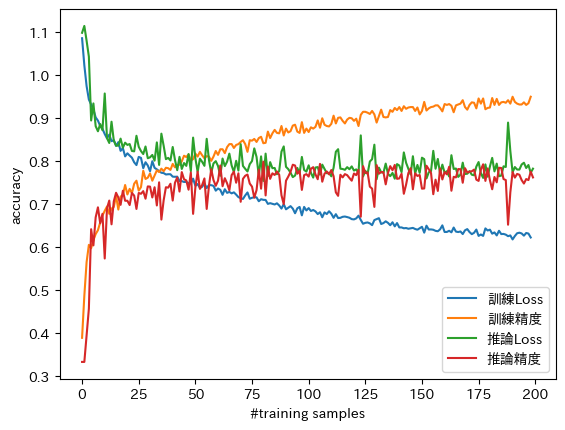

In [33]:
plt.figure()
df_train_loss_acc.plot()

plt.xlabel('#training samples')
plt.ylabel('accuracy')
plt.legend(loc='lower right')
#plt.ylim([0, 1.01])
plt.show()

## ConfusionMatrix

In [34]:
load_weights = torch.load('model_weight.pth')
model.load_state_dict(load_weights)

<All keys matched successfully>

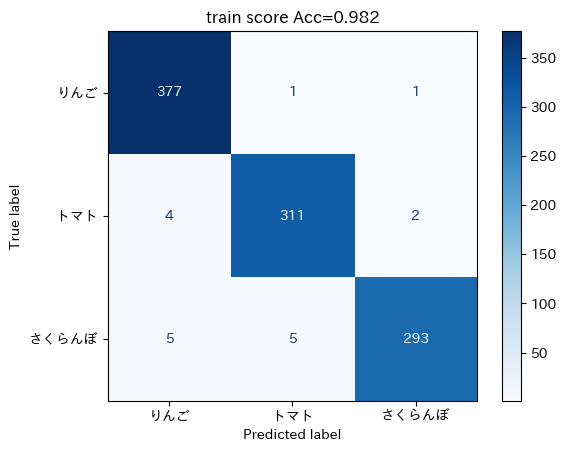

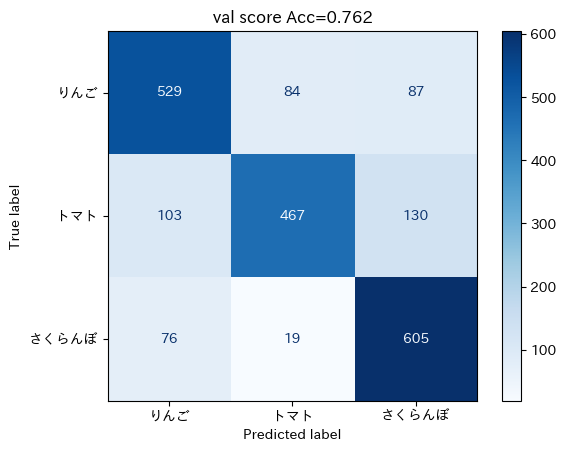

In [35]:
for phase, dataloader in dataloaders_dict.items():
  y_true = []
  y_pred = []

  for inputs, labels in dataloader:
    model.eval()
    with torch.set_grad_enabled(False):
      outputs = model.to('cpu')(inputs)
      _, preds = torch.max(outputs, 1)

    y_true.extend(labels.tolist())
    y_pred.extend(preds.tolist())

  #スコアの計算
  accuracy = accuracy_score(y_true, y_pred)

  #混合行列
  cm = confusion_matrix(y_pred = y_pred, y_true = y_true)
  cmp = ConfusionMatrixDisplay(cm, display_labels = ["りんご", "トマト", "さくらんぼ"])
  cmp.plot(cmap = plt.cm.Blues)
  cmp.ax_.set_title(f"{phase} score Acc={accuracy:.3f}")
  plt.show()

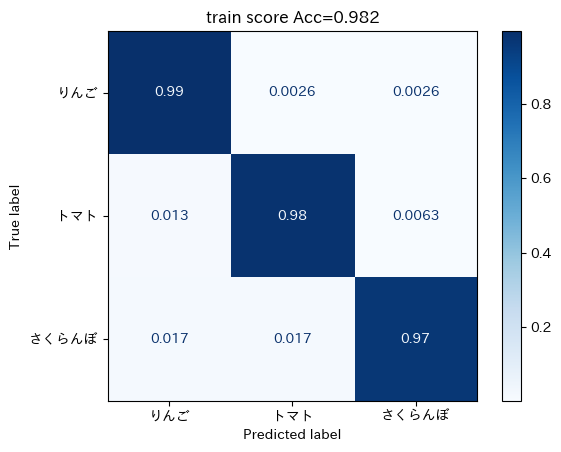

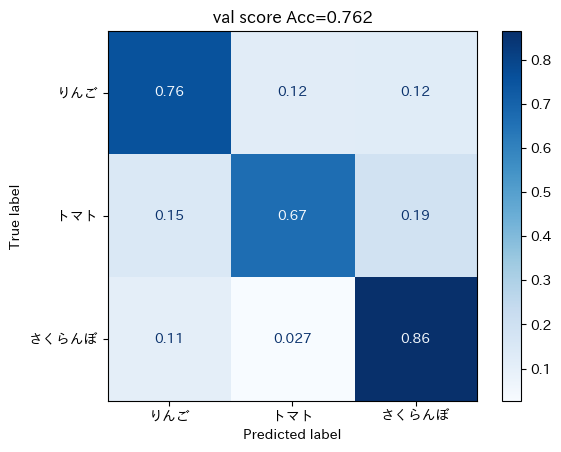

In [36]:
for phase, dataloader in dataloaders_dict.items():
  y_true = []
  y_pred = []

  for inputs, labels in dataloader:
    model.eval()
    with torch.set_grad_enabled(False):
      outputs = model.to('cpu')(inputs)
      _, preds = torch.max(outputs, 1)

    y_true.extend(labels.tolist())
    y_pred.extend(preds.tolist())

  #スコアの計算
  accuracy = accuracy_score(y_true, y_pred)

  #混合行列
  cm = confusion_matrix(y_pred = y_pred, y_true = y_true, normalize = "true")
  cmp = ConfusionMatrixDisplay(cm, display_labels = ["りんご", "トマト", "さくらんぼ"])
  cmp.plot(cmap = plt.cm.Blues)
  cmp.ax_.set_title(f"{phase} score Acc={accuracy:.3f}")
  plt.show()